# Word2vec only with one matrix

Choose CBOW/Skip-Gram again. Implement it, but now without second `h_dim x vocab_size` matrix. Remember what was the loss function in Stanford lecture.

$$ L = - \frac{1}{T} \sum_{t=1}^T \sum_{-m <= j <= m, j \ne 0} log P(w_{t+j}|w_{t+j-m})$$


$$ P(w_h | w_i) = \frac{exp(s(v_i, v_h))}{\sum exp(s(v_i, v_w))}$$

Where $s(x, y)$ is a similarity function. It is common to use dot-product here $s(x, y) = s^Ty$. The sum in the denominator is across all vocabulary for $P$ to be a probability distribution.

Look to this formula closer. There is no projection back to vocabulary dimension in the loss! So, we can reduce the number of parameters by the factor of two by not using the second matrix $W'$. Your new task is to code CBOW / SkipGram with this loss.

**Main idea:**

We project word vectors to some space. Next, we work with the space itself. We update projection matrix weights so that similar (in the terms of Distributional semantics) words have similar vectors in that space. We don't need to solve classification task explicitly here.

**Tip:**

Work with matrix operations and not with nn.layers / keras.layers.

**Results of this task** (the very same as in task 3):
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies


**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)



Supplementary materials:
  * [cs224n winter 2017 lecture 2 video](https://www.youtube.com/watch?v=ERibwqs9p38&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6&index=2)
  * [cs224n winter 2019 lecture 1 slides](http://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture01-wordvecs1.pdf)

In [0]:
"""my implemenatation of word2vec embedding model with only one matrix of embeddings: https://arxiv.org/pdf/1411.2738.pdf"""
import tensorflow as tf
from tensorflow.train import AdamOptimizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorboardcolab import *
from operator import itemgetter

In [0]:
"""batcher class for the model"""
import numpy as np
import random
from collections import Counter

unknown_token = "UNK"

class SkipGramBatcher:
    def __init__(self, window_size=5, least_freq=3):
        self.least_freq = least_freq
        self.text = None
        self.vocab = None
        self.vocab_size = None
        self.word2index = None
        self.index2word = None
        self.window_size = window_size
        self.current_index = 0
        self.current_diff = -window_size
        self.total_size = 0
    
    def preprocess(self, text):
        """replace words with frequency < least_freq with unknown_token
        and save the text
        """
        counter = Counter(text)
        def get_token(word):
            if counter[word] < self.least_freq:
                return unknown_token
            else:
                return word.lower()
        self.text = [get_token(word) for word in text]
    
    def fit_text(self, text):
        """init text, vocab, word2ind, ind2word"""
        self.preprocess(text)
        self.vocab = np.unique(self.text)
        self.vocab_size = self.vocab.shape[0]
        self.word2index = dict(zip(self.vocab, range(self.vocab.shape[0])))
        self.index2word = dict(zip(range(self.vocab.shape[0]), self.vocab))
        self.total_size = (len(self.text) - 3 * self.window_size) * self.window_size * 2
        
    def most_frequent(self, num=25):
        """get most frequent words from the text"""
        counter = Counter(self.text)
        return counter.most_common(num)
        
    def least_frequent(self, num=25):
        """get least frequent words from the text"""
        counter = Counter(self.text)
        return counter.most_common()[:-num - 1:-1]
        
    def indices_to_words(self, x_batch):
        """return array of words out of array of indices"""
        return np.array([self.index2word[index] for index in x_batch])
    
    def words_to_indices(self, words):
        """return array of indices out of array of words"""
        return np.array([self.word2index[word] for word in words])
    
    def get_next_index_and_diff(self, current_index, current_diff):
        if (current_diff == self.window_size):
            current_diff = -self.window_size
            current_index += 1
            current_index %= len(self.text)
        else:
            if current_diff == -1:
                current_diff = 1
            else:
                current_diff += 1
        return current_index, current_diff

    
    def get_batch(self, batch_size=100):
        """return batch of indices for x and for labels consequently"""
        x_batch = []
        labels_batch = []
        while len(x_batch) < batch_size:
            label_index_in_text = self.current_index + self.current_diff 
            if (label_index_in_text < 0 or label_index_in_text >= len(self.text)):
                index, diff = self.get_next_index_and_diff(self.current_index, self.current_diff)
                self.current_index = index
                self.current_diff = diff
                continue
                
            word = self.text[self.current_index]
            word_index = self.word2index[word]
            label = self.text[self.current_index + self.current_diff]
            label_index = self.word2index[label]
            
            x_batch.append(word_index)
            labels_batch.append(label_index)
            
            index, diff = self.get_next_index_and_diff(self.current_index, self.current_diff)
            self.current_index = index
            self.current_diff = diff
            
        assert len(x_batch) == batch_size
        assert len(labels_batch) == batch_size
        
        x_batch = np.array(x_batch)
        labels_batch = np.array(labels_batch)
        
        permut = np.random.permutation(range(batch_size))
        x_batch = x_batch[permut]
        labels_batch = labels_batch[permut]
        return x_batch, labels_batch
      
    def get_random_batch(self, batch_size=100):
        """return batch of indices for x and for labels randomly"""
        x_batch = []
        labels_batch = []
        
        indices = np.random.choice(np.arange(self.window_size + 100, len(self.text) - self.window_size - 100), batch_size, replace=False)
        words = itemgetter(*indices.tolist())(self.text)
        x_batch = [self.word2index[word] for word in words]
        
        diffs = np.random.randint(-self.window_size, +self.window_size, size=batch_size)
        label_indices = indices + diffs
        labels = itemgetter(*label_indices.tolist())(self.text)
        labels_batch = [self.word2index[label] for label in labels]
        
        x_batch = np.array(x_batch)
        labels_batch = np.array(labels_batch)
        return x_batch, labels_batch
        
    def batch_generator(self, batch_size=100):
        """generator for the batches"""
        while True:
            x_batch, labels_batch = self.get_batch(batch_size)
            yield x_batch, labels_batch

In [4]:
"""preparing data for training, the data is text8 - preprocessed text with 17005208 words"""
!mkdir logs
!ls
!wget http://mattmahoney.net/dc/text8.zip

!ls
!unzip text8.zip

filename = 'text8' #file with the raw text
text = []
with open('text8', mode='r') as file:
    line = file.readline()
    while line:
        text += line.lower().split(' ')
        line = file.readline()

logs  sample_data
--2019-03-06 13:28:35--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.75
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  1.97MB/s    in 15s     

2019-03-06 13:28:55 (1.93 MB/s) - ‘text8.zip’ saved [31344016/31344016]

logs  sample_data  text8.zip
Archive:  text8.zip
  inflating: text8                   
17005208


In [0]:
"""initializing batcher for the model"""
batcher = SkipGramBatcher(window_size=5, least_freq=7)
batcher.fit_text(text[:1000000])

In [41]:
"""gpu usage"""
USE_GPU = True
if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'
    
print('Using device: ', device)

Using device:  /device:GPU:0


In [0]:
"""function for weights initialization"""
def kaiming_normal(shape):
    return tf.random_normal(shape) * np.sqrt(2.0 / shape[0])

In [0]:
"""logging parameters"""
save_every = 200
loss_every = 200
summary_every = 100
log_every = 50
USE_TENSORBOARDCOLAB = True
model_name = 'one_matrix_'

In [0]:
"""word2vec class"""
class Word2Vec:
    def __init__(self, vocab_size, embeddings_size):
        tf.reset_default_graph()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
        self.vocab_size = vocab_size
        self.embeddings_size = embeddings_size
        
    def close(self):
        tf.reset_default_graph()
        self.sess.close()
        
    def init_weights(self):
        self.w1 = tf.Variable(kaiming_normal((self.vocab_size, self.embeddings_size)), name='w1')
        
    def model_fn(self, x):
        """one matrix model"""
        x = tf.matmul(x, self.w1)
        x = tf.matmul(x, tf.transpose(self.w1))
        return x
    
    def get_loss(self, scores, y):
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(losses)
        return loss
    
    def train(self, batcher, batch_size=10, epochs=3, learning_rate=0.01):        
        with tf.device(device):
            self.init_weights()
            
            x = tf.placeholder(dtype=tf.int32, shape=(batch_size))
            y = tf.placeholder(dtype=tf.int32, shape=(batch_size))
            
            x_one_hot = tf.one_hot(x, self.vocab_size)
            
            scores = self.model_fn(x_one_hot)
            loss = self.get_loss(scores, y)
            tf.summary.scalar('cross_entropy', loss)
            
            train_op = AdamOptimizer(learning_rate).minimize(loss)
            
            saver = tf.train.Saver({"w1" : self.w1})
            merged = tf.summary.merge_all()
            
            if USE_TENSORBOARDCOLAB:
                tbc = TensorBoardColab()
                train_writer = tbc.get_writer()
                print()
                print('initialized writer for tensorboard logging...')
                print()
            else:
                train_writer = tf.summary.FileWriter('./tensorboard/train')
            
            #training
            self.sess.run(tf.global_variables_initializer())
            
            min_loss = 1e9
            losses = []
            print('Starting training...')
            try:
                for epoch in range(epochs):
                    iter_count = int(batcher.total_size / batch_size)
                    for step in range(iter_count):
                        x_batch, labels_batch = batcher.get_batch(batch_size)
                        feed_dict = {x : x_batch, y : labels_batch}
                        
                        if step % summary_every == 0:
                            print('writing summary to tensorboard...')
                            print()
                            summary = self.sess.run(merged, feed_dict=feed_dict)
                            train_writer.add_summary(summary, iter_count * epoch + step)
                        
                        np_loss, _ = self.sess.run([loss, train_op], feed_dict=feed_dict)
                        
                        if step % log_every == 0:
                            print('running epoch: {}, step: {}, loss = {}...'.format(epoch, step, np_loss))
                            print()

                        if min_loss > np_loss:
                            saver.save(self.sess, "./logs/" + model_name + "model_min_loss.ckpt")
                            print("minimal loss updated from {} to {} | at step {}...".format(min_loss, np_loss, step))
                            min_loss = np_loss
                            print("Model weights and loss saved in ./logs/" + model_name + "model_min_loss.ckpt | at step {}...".format(step))
                            print()
                        if step % save_every == 0:
                            saver.save(self.sess, "./logs/" + model_name + "model_default_save.ckpt")
                            print("Model with loss = {} saved to ./logs/" + model_name + "model_default_save.ckpt | at step {}...".format(np_loss, step))
                            print()
                        if step % loss_every == 0:
                            if len(losses) > 10000000:
                                print('Already a lot losses...')
                            else:
                                losses.append(np_loss)
                                print("Losses saved to ./logs/" + model_name + "losses_history... | at step {}".format(step))
                                print()
                                np.save("./logs/" + model_name + "losses_history", np.array(losses))
            except KeyboardInterrupt:
                print('KeyboardInterrupt')
    
    def get_vectors_from_words(self, batcher, words):
        """return embeddings out of words"""
        if not isinstance(words, list):
            words = [words]
        with tf.device(device):
            indexes = [batcher.word2index[word] for word in words]
            x = tf.placeholder(dtype=tf.int32, shape=(len(indexes)))
            x_one_hot = tf.one_hot(x, self.vocab_size)
            x_one_hot = tf.cast(x_one_hot, tf.float32)
            predicted = tf.matmul(x_one_hot, self.w1)
           
            embeddings = self.sess.run(predicted, feed_dict={x : indexes})
            return embeddings
    
    def get_vectors_from_indexes(self, batcher, indexes):
        """return embeddings out of indixes in vocabulary list"""
        words = [batcher.index2word[index] for index in indexes]
        return self.get_vectors_from_words(batcher, words)

In [48]:
"""training the model (check tensorboard visualization)"""
"""training for about 2.5 hours"""
EMBEDDINGS_SIZE = 300
BATCH_SIZE = 10000
EPOCHS = 100
LEARNING_RATE = 0.01
model = Word2Vec(batcher.vocab_size, EMBEDDINGS_SIZE)
model.train(batcher, BATCH_SIZE, EPOCHS, LEARNING_RATE)

Wait for 8 seconds...
TensorBoard link:
https://06bc7192.ngrok.io

initialized writer for tensorboard logging...

Starting training...
writing summary to tensorboard...

running epoch: 0, step: 0, loss = 9.300548553466797...

minimal loss updated from 1000000000.0 to 9.300548553466797 | at step 0...
Model weights and loss saved in ./logs/one_matrix_model_min_loss.ckpt | at step 0...

Model with loss = {} saved to ./logs/one_matrix_model_default_save.ckpt | at step 9.300548553466797...

Losses saved to ./logs/one_matrix_losses_history... | at step 0

minimal loss updated from 9.300548553466797 to 9.2929105758667 | at step 1...
Model weights and loss saved in ./logs/one_matrix_model_min_loss.ckpt | at step 1...

minimal loss updated from 9.2929105758667 to 9.26429271697998 | at step 2...
Model weights and loss saved in ./logs/one_matrix_model_min_loss.ckpt | at step 2...

minimal loss updated from 9.26429271697998 to 9.228614807128906 | at step 3...
Model weights and loss saved in ./logs

In [0]:
"""plotting the vectors using TSNE"""
def plot_words(indixes, embeddings):
    """embeddings of shape num_values * embed_dimenssion"""
    tsne = TSNE(n_components=2, init="pca", n_iter=1000)
    transformed = tsne.fit_transform(embeddings)
    print('TSNE calculated...')
    
    plt.figure(figsize=(15, 15))
    words = [batcher.index2word[index] for index in indixes]
    for i, word in enumerate(words):
        x, y = transformed[i, :]
        plt.scatter(x, y)
        plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom")
    plt.show()

In [0]:
"""function to map token to corresponding word vector"""
embeddings = model.get_vectors_from_words(batcher, ['anarchism', 'UNK'])

(200, 300)
TSNE calculated...


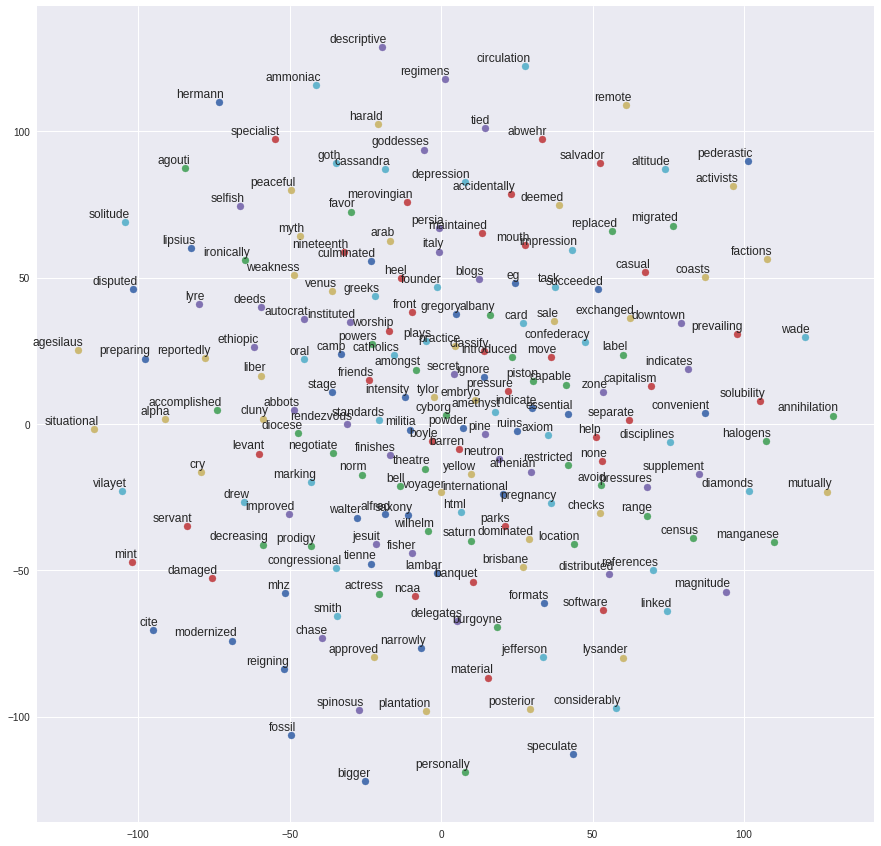

In [54]:
"""plotting the embeddings"""
indices = np.arange(batcher.vocab_size)
np.random.shuffle(indices)
indices = indices[:200]
embed_from_indices = model.get_vectors_from_indexes(batcher, indices)
print(embed_from_indices.shape)

plot_words(indices, embed_from_indices)

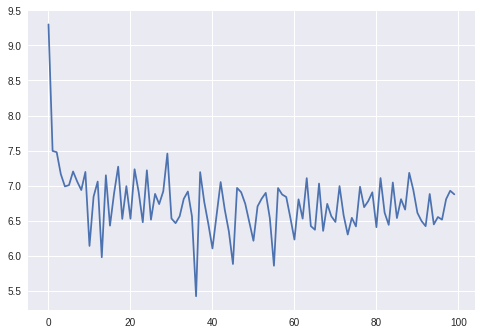

In [56]:
"""plot loss without tensorboard"""
losses = np.load("./logs/" + model_name + "losses_history.npy")
plt.plot(losses)
plt.show()

In [57]:
print(batcher.vocab_size)
embeddings = model.get_vectors_from_indexes(batcher, range(batcher.vocab_size))

10953


In [0]:
"""nearest neighbors, word analogies using gensim"""
def create_file_for_gensim(embeddings, vocab_size, vec_size, filename):
    with open(filename, 'w') as f:
        f.write(str(vocab_size) + ' ' + str(vec_size) + '\n')
        for i in range(vocab_size):
            to_write = ' '.join([batcher.index2word[i]] + [str(num) for num in embeddings[i]])
            f.write(to_write + '\n')

create_file_for_gensim(embeddings, embeddings.shape[0], EMBEDDINGS_SIZE, 'word2vec.vec')

In [0]:
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format('word2vec.vec', binary=False)

def print_similar(similar_to):
    for similar in w2v.similar_by_word(similar_to)[:20]:
        print("word: {0}, similarity: {1:.2f}".format(similar[0], similar[1]))

In [64]:
print_similar('tall')

word: inserted, similarity: 0.81
word: feet, similarity: 0.81
word: metres, similarity: 0.76
word: cm, similarity: 0.76
word: two, similarity: 0.76
word: five, similarity: 0.76
word: three, similarity: 0.76
word: inches, similarity: 0.76
word: about, similarity: 0.75
word: towers, similarity: 0.75


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [61]:
print_similar('queen')

word: king, similarity: 0.86
word: henry, similarity: 0.84
word: france, similarity: 0.84
word: UNK, similarity: 0.84
word: of, similarity: 0.84
word: crowned, similarity: 0.83
word: sweden, similarity: 0.83
word: ii, similarity: 0.83
word: de, similarity: 0.83
word: s, similarity: 0.83


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [65]:
similar_words = w2v.most_similar(positive=['girl', 'father'], negative=['mother'])
for similar in similar_words:
    print("word: {0}, similarity: {1:.2f}".format(similar[0], similar[1]))

word: children, similarity: 0.73
word: was, similarity: 0.73
word: boy, similarity: 0.72
word: after, similarity: 0.72
word: born, similarity: 0.72
word: infancy, similarity: 0.72
word: a, similarity: 0.72
word: in, similarity: 0.72
word: who, similarity: 0.72
word: UNK, similarity: 0.71


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [89]:
similar_words = w2v.most_similar(positive=['king', 'woman'], negative=['man'])
for similar in similar_words:
    print("word: {0}, similarity: {1:.2f}".format(similar[0], similar[1]))

word: ii, similarity: 0.74
word: prince, similarity: 0.72
word: son, similarity: 0.72
word: queen, similarity: 0.72
word: after, similarity: 0.72
word: theodosius, similarity: 0.72
word: three, similarity: 0.71
word: florence, similarity: 0.71
word: neil, similarity: 0.71
word: julius, similarity: 0.71


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
"""nearest neighbors, word analogies using my own implemetation"""
"""as it can be seen we got the same results!!!!!!!!!"""
"""as we see one matrix model is good for word analogies, but not for nearest neighbours"""
def get_similar_by_word(embeddings, similar_to, num_top=10):
    index = batcher.word2index[similar_to]
    with tf.device(device):
        embed = tf.placeholder(dtype=tf.float32, shape=(embeddings.shape[0], embeddings.shape[1]), name='embeddings')
        norm_embed = tf.nn.l2_normalize(embed, 1)
        nearby_index = tf.placeholder(tf.int32, shape=(), name='nearby_index')
        nearby_embed = tf.gather(norm_embed, nearby_index)
        nearby_embed = tf.reshape(nearby_embed, (1, -1))
        nearby_dist = tf.matmul(nearby_embed, norm_embed, transpose_b=True)
        nearby_val, nearby_idx = tf.nn.top_k(nearby_dist, min(num_top, embeddings.shape[0]))
        
        feed_dict = {embed : embeddings, nearby_index : index}
        vals, idxs = model.sess.run([nearby_val, nearby_idx], feed_dict=feed_dict)
        words = np.array([batcher.index2word[idx] for idx in idxs.flatten()])
        return vals.flatten()[1:], words[1:]
      
def get_analogy_by_word(embeddings, positive, negative, num_top=10):
    a = batcher.word2index[negative[0]]
    b = batcher.word2index[positive[0]]
    c = batcher.word2index[positive[1]]
    with tf.device(device):
        embed = tf.placeholder(dtype=tf.float32, shape=(embeddings.shape[0], embeddings.shape[1]), name='embeddings')
        norm_embed = tf.nn.l2_normalize(embed, 1)
        a_index = tf.placeholder(tf.int32, shape=(), name='a_index')
        b_index = tf.placeholder(tf.int32, shape=(), name='b_index')
        c_index = tf.placeholder(tf.int32, shape=(), name='c_index')
        a_embed = tf.reshape(tf.gather(norm_embed, a_index), (1, -1))
        b_embed = tf.reshape(tf.gather(norm_embed, b_index), (1, -1))
        c_embed = tf.reshape(tf.gather(norm_embed, c_index), (1, -1))
        target_embed = c_embed + b_embed - a_embed
        target_dist = tf.matmul(target_embed, norm_embed, transpose_b=True)
        target_val, target_idx = tf.nn.top_k(target_dist, min(num_top, embeddings.shape[0]))
        
        feed_dict = {embed : embeddings, a_index : a, b_index : b, c_index : c}
        vals, idxs = model.sess.run([target_val, target_idx], feed_dict=feed_dict)
        words = np.array([batcher.index2word[idx] for idx in idxs.flatten()])
        return vals.flatten(), words


In [76]:
vals, words = get_similar_by_word(embeddings, 'she')
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: her, similarity: 0.94
word: he, similarity: 0.90
word: was, similarity: 0.89
word: him, similarity: 0.89
word: zeus, similarity: 0.88
word: to, similarity: 0.88
word: had, similarity: 0.88
word: UNK, similarity: 0.88
word: a, similarity: 0.88


In [68]:
vals, words = get_similar_by_word(embeddings, 'queen')
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: king, similarity: 0.86
word: henry, similarity: 0.84
word: france, similarity: 0.84
word: UNK, similarity: 0.84
word: of, similarity: 0.84
word: crowned, similarity: 0.83
word: sweden, similarity: 0.83
word: ii, similarity: 0.83
word: de, similarity: 0.83


In [91]:
vals, words = get_analogy_by_word(embeddings, positive=['father', 'girl'], negative=['mother'])
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: girl, similarity: 1.00
word: father, similarity: 0.83
word: children, similarity: 0.82
word: was, similarity: 0.81
word: boy, similarity: 0.81
word: after, similarity: 0.81
word: born, similarity: 0.80
word: infancy, similarity: 0.80
word: a, similarity: 0.80
word: in, similarity: 0.80


In [90]:
vals, words = get_analogy_by_word(embeddings, positive=['woman', 'king'], negative=['man'])
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: king, similarity: 1.00
word: woman, similarity: 0.99
word: ii, similarity: 0.87
word: prince, similarity: 0.85
word: son, similarity: 0.85
word: queen, similarity: 0.85
word: after, similarity: 0.85
word: theodosius, similarity: 0.85
word: three, similarity: 0.84
word: florence, similarity: 0.84


In [0]:
np.save("./logs/" + model_name + "embeddings", embeddings)

In [0]:
"""download graph and loss to visualize them localy (ngrock is too slow with VPN) """
from google.colab import files
files.download("./logs/" + model_name + "embeddings.npy") 

In [0]:
"""model destructor (closses tf.Session())"""
model.close()